# Estimating (classification): kNN, decision trees

Machine learning enables the use of algorithms to classify data in several different ways. In order to accomplish this kind of task, the algorithms take inputs and expected outputs and learn from them. The inputs are features, they are characteristics of the studied phenomenon that can be quantified or somehow measured.

These features are introduced into a machine learning algorithm that tries to discern patterns in their relationship with a targeted label. A label identifies an observation as classified, in terms of category or type of observation. 

Classification is a type of supervised learning. In this approach, the computer program learns from the input data and then uses this learning to classify new observations.

In this tutorial, we are going to take a look at two classification algorithms: **K-Nearest Neighbor** and **Decision Trees**.


**SCKIT LEARN ZERO**
* K-Nearest Neighbor
* Decision Trees


### Importing Python libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Tip: to get familiar with pandas, make sure to check [pandas-zero](https://github.com/leobezerra/pandas-zero) out.

### Download dataset

We are going to use the [Titanic Kaggle's dataset](https://www.kaggle.com/c/titanic) from Kaggle competitions. To download the data follow [first stage of this tutorial](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0), it shows how to connect Kaggle API to Google Colaboratory and download datasets directly from Kaggle to your Colab.

**Note**: you neet accept the Competition Rules to gain access to the dataset. 



In [ ]:
# upload the kaggle.json to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joooliveira","key":"cecab6f83237691aafe27aa94d2a00d6"}'}

In [ ]:
# install the kaggle library
!pip install kaggle

In [ ]:
# download the dataset using the kaggle lib
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.41MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 59.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.9MB/s]


## Preprocessing the data

Let's begin with an overall look at the data by checking the fields we've got and their meanings.

In [ ]:
# Importing the training dataset
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To undestand more about our dataset, here is the data dictionary:
1. `Pclass`: Ticket class (`1` = **1st**, `2` = **2s**, `3` = **3st**) 
2. `Survived` : `0`: = **No**, `1` = **Yes**
2. `Sex` : `0` = **Female**, `1` = **Male**
3. `Age`: Age in year
4. `Sibsp`: Nmber of Siblings/Spouses Aboard (brother, sister, stepbrother, stepsister, husband, wife)
5. `Parch`: Number of Parents/Children Aboard (mother, father,  daughter, son, stepdaughter, stepson)
6. `Ticket`: Ticket number
7. `Fare`: Passenger fare
8. `Cabin`: Cabin number
9. `Embarked`: Por of Embarkation (`C` = **Cherbourg**, `Q` = **Queenstown**, `S` = **Southampton**)

Let's see how much data we have calling the `shape` function. The train data has 891 rows and 12 features.

In [ ]:
df.shape

(891, 12)

In [ ]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We are not interested in the features like `name`, `ticket`, or `cabin`. So let's delete everything that we don't need.

In [ ]:
columns_to_drop = ['Name', 'Ticket', 'Cabin']
train = df.drop(columns=columns_to_drop, axis=1).copy()
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Fill `NaN` values



In [ ]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

The Age column has 177 NaN values, so we're going to fill with median age.

In [ ]:
median_age = train["Age"].median()
train["Age"] = train["Age"].fillna(median_age)

To embarked column, let's fill the nan values with the value for embarkation with max frequency.

In [ ]:
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

In [ ]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

## k-Nearest Neighbors



With a cleaner dataset, we can start the algorithms' exploration. First, we have k-Nearest Neighbors or kNN.



*   **What it is?**

  KNN is a non-parametric and lazy learning algorithm. Non-parametric means there is no assumption for underlying data distribution. In other words, the model structure determined if from the dataset. Lazy algorithm means it does not need any training data points for model generation. All training data used in the testing phase.

*  **When to use**

 This will be very helpful in practice where most of the datasets that do not follow mathematical theoretical assumptions and by using this, you have more testing and less training phases.

Categorical data are harder to use as a feature on most machine learning algorithms. So, a common practice is to transform categorical data, such as strings, into numerical values. Also, we can create new features based on data transformation or mixes.

In [ ]:
mapping_embarked = {'C': 0, 'Q': 1, 'S': 2}
train.replace({'Embarked': mapping_embarked}, inplace=True)

In [ ]:
mapping_sex = {'male': 0, 'female': 1}
train.replace({'Sex': mapping_sex}, inplace=True)

We can transform the age feature into a new feature:

In [ ]:
train["Adult"] = 0
train.loc[train["Age"] >= 18, 'Adult'] = 1

In [ ]:
train["Family"] = train["SibSp"] + train["Parch"]

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Adult,Family
0,1,0,3,0,22.0,1,0,7.2500,2,1,1
1,2,1,1,1,38.0,1,0,71.2833,0,1,1
2,3,1,3,1,26.0,0,0,7.9250,2,1,0
3,4,1,1,1,35.0,1,0,53.1000,2,1,1
4,5,0,3,0,35.0,0,0,8.0500,2,1,0


Now let's use a heatmap to put the correlations together and compare between the variables.

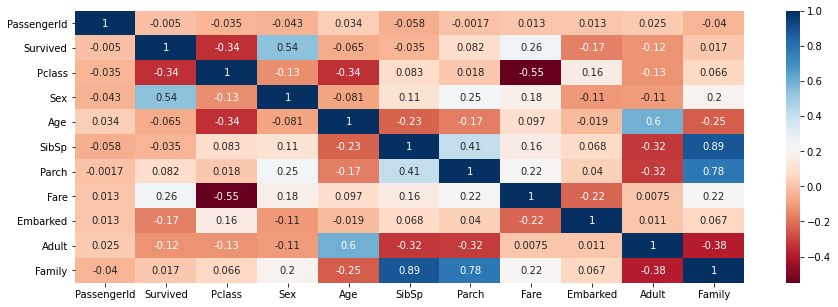

In [ ]:
import seaborn as sns

plt.subplots(figsize=(15,5))
sns.heatmap(train.corr(), cmap='RdBu', cbar=True, annot=True)

By analyzing those arguments, we can see the highest values of correlation with Survived are parch, fare and sex as opposed to pclass and embarked, for exemple. We can use this perception to drop some of them and make the study more accurate.

Let's split up our data into input (`X`) and target (`y`). The input has every column except `Survived`, because `Survived` is what we're trying to predict (it is our target).

In [ ]:
input_columns = ['Pclass', 'Sex', 'Embarked', 'Adult']
X = train[input_columns].copy()

In [ ]:
y = train['Survived'].values

We're dividing the dataset into 70% training data and 30% test data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

The **k**-neighbors classification in KNeighborsClassifier is the most commonly used technique. It implements learning based on the  nearest neighbors of each query point, which is an integer value specified by the user. The optimal choice of the value k is highly data-dependent: in general a larger **k** suppresses the effects of noise, but makes the classification boundaries less distinct.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Our model predicted that one of the first 5 passagers survived. 

In [ ]:
# show first 5 model predictions on the test data
knn.predict(X_test)[0:5]

array([0, 0, 0, 1, 0])

To see how accurate our model is, we use the `score` function. We need to pass our test input and target data to see how well our model predictions match up to the actual results.

In [ ]:
# check accuracy of our model on the test data
knn.score(X_test, y_test)

0.8134328358208955

We can use more techniques to incrises the ac, like k-Fold Cross-Validation or GridSearchCV. 

### Predict survival

In [ ]:
test = pd.read_csv('test.csv') 

Fill nan values of `Age`, `Fare` and `Embarked`.

In [ ]:
median_age = test["Age"].median()
test["Age"] = test["Age"].fillna(median_age)

test["Fare"] = test["Fare"].fillna(test['Fare'].mode()[0])

test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])

Change `Sex` and `Embarked` to numerical values, and create `Adult` column.

In [ ]:
mapping_sex = {'male': 1, 'female': 2}
test['Sex'] = test.replace({'Sex': mapping_sex})

mapping_embarked = {'S': 1, 'C': 2, 'Q': 3}
test['Embarked'] = test.replace({'Embarked': mapping_embarked})

test["Adult"] = 0
test.loc[test["Age"] >= 18, 'Adult'] = 1

In [ ]:
test_set = test[input_columns].copy()

In [ ]:
test_set.isna().sum()

Pclass      0
Sex         0
Embarked    0
Adult       0
dtype: int64

In [ ]:
final_pred = knn.predict(test_set)

In [ ]:
test['Survived'] = pd.Series(final_pred, index=test.index)

In [ ]:
test[['PassengerId', 'Survived']]

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


## Decision Trees
* **What is it ?**  
Decision Tree is a supervised learning method based on flowchart-like structure, in which each internal node represents a "test" on an attribute and each leaf node represents a class label.  
* **When to use**  
This algorithm can be used for both **Classification** and **Regression** Problems, especially when the goal is exploratory analysis, as to understand the data relationship is very intuitive in a tree hierarchy structure.

### Classification Tree

We're going to use the same [Kaggle's Titanic dataset](https://www.kaggle.com/c/titanic), but this time by applying the Classification Tree approach.

#### Libraries

In [ ]:
from sklearn import tree
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#### Filtering the dataset

In [ ]:
columns_to_drop = ['Name', 'PassengerId', 'Pclass', 'Name', 'Fare', 'Ticket', 'Cabin', 'Embarked']
df = pd.read_csv('train.csv').drop(columns=columns_to_drop, axis=1)
df.tail()

,Survived,Sex,Age,SibSp,Parch
886,0,male,27.0,0,0
887,1,female,19.0,0,0
888,0,female,NaN,1,2
889,1,male,26.0,0,0
890,0,male,32.0,0,0


### Preprocessing
As we've seen at the dataset dictionary previously, there are a lot of missing values in `Age` label, two choices can be made, fill this values or eliminate the complete row from dataset. Here we will simply remove the rows with `NaN` from the Data.

In [ ]:
label = preprocessing.LabelEncoder()
df['Sex']= label.fit_transform(df['Sex'])
df = df.dropna(axis=0)  
df.head()

,Survived,Sex,Age,SibSp,Parch
0,0,1,22.0,1,0
1,1,0,38.0,1,0
2,1,0,26.0,0,0
3,1,0,35.0,1,0
4,0,1,35.0,0,0


### Cross Validation

It's important to determine the maximum number of attributes the model will use for the predictions, which is known as 'max_depth'. To find the best value for this parameter we cal iterate over all the possible depths and measure the accuracy. To a better understand about iterations in Python we suggest to take a look on this [Datacamp article](https://www.datacamp.com/community/tutorials/loops-python-tutorial), especially in the "for loop" section.

To evaluate this accuracy we are going to use a method called Cross Validation. This model validation technique splits the training dataset in a given number of "folds". Each split uses different data for training and testing purposes, allowing the model to be trained and tested with different data each time. This allows the algorithm to be trained and tested with all available data across all folds, avoiding any splitting bias and giving a good idea of the generalisation of the chosen model.

To make this validation, we are going to use K-fold, the most well-known and used cross-validation method.

In [ ]:
# Define the number of folds
kf = KFold(n_splits=8)  
# Collect quantity of dataset attributes
max_attributes = len(list(df))
# Getting depth values ​​to do the iteration
depth_range = range(1, max_attributes + 1)
# List to store the accuracies
accuracies = list()   

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    
    # Split data into training and test set.
    for train_fold, valid_fold in kf.split(df):
        fold_train = df.iloc[train_fold] 
        fold_valid = df.iloc[valid_fold]

        # Fitting the model with the fold train data
        model = tree_model.fit(X = fold_train.drop(['Survived'], axis=1), y = fold_train["Survived"])
        # Calculate accuracy with the fold validation data
        valid_accuracy = model.score(X = fold_valid.drop(['Survived'], axis=1), y = fold_valid["Survived"])

        fold_accuracy.append(valid_accuracy)

    # Calculate average accuracy
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Show the results
depth_df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
depth_df = depth_df[["Max Depth", "Average Accuracy"]]
print(depth_df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.780056
         2          0.777310
         3          0.803886
         4          0.812282
         5          0.808099


By the results above, we can see that the best max_depth  seems therefore to be 4 (81.2282% average accuracy across the 8 folds). We are going to use this value in the following topic.

### Applying Decision Tree algorithm using Sickit Learn
With a clean dataset, we can use the **Scikit Learn** library to create a Decision Tree model.    

Here We use the `train_test_split` method to separate data into test and train data. This is a important step to measure the accuracy of the model.     
One of the advantages of using decision trees is that you can explain every step of the algorithm and this is very usefull, especially for **Decision Making** process.
Besides that, the algorithm separete the best features, starting from the root to the leaves.

In [ ]:
columns_x = ['Sex', 'Age', 'SibSp', 'Parch']
X = df.loc[:,columns_x]
y = df.drop(columns_x, axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=1)

clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.8461538461538461

###Plot of the Classification Tree Model
Here we can see a plot of the decision making strategy that our algorithm will take to predict if a passenger died or survived of the titanic tragedy.

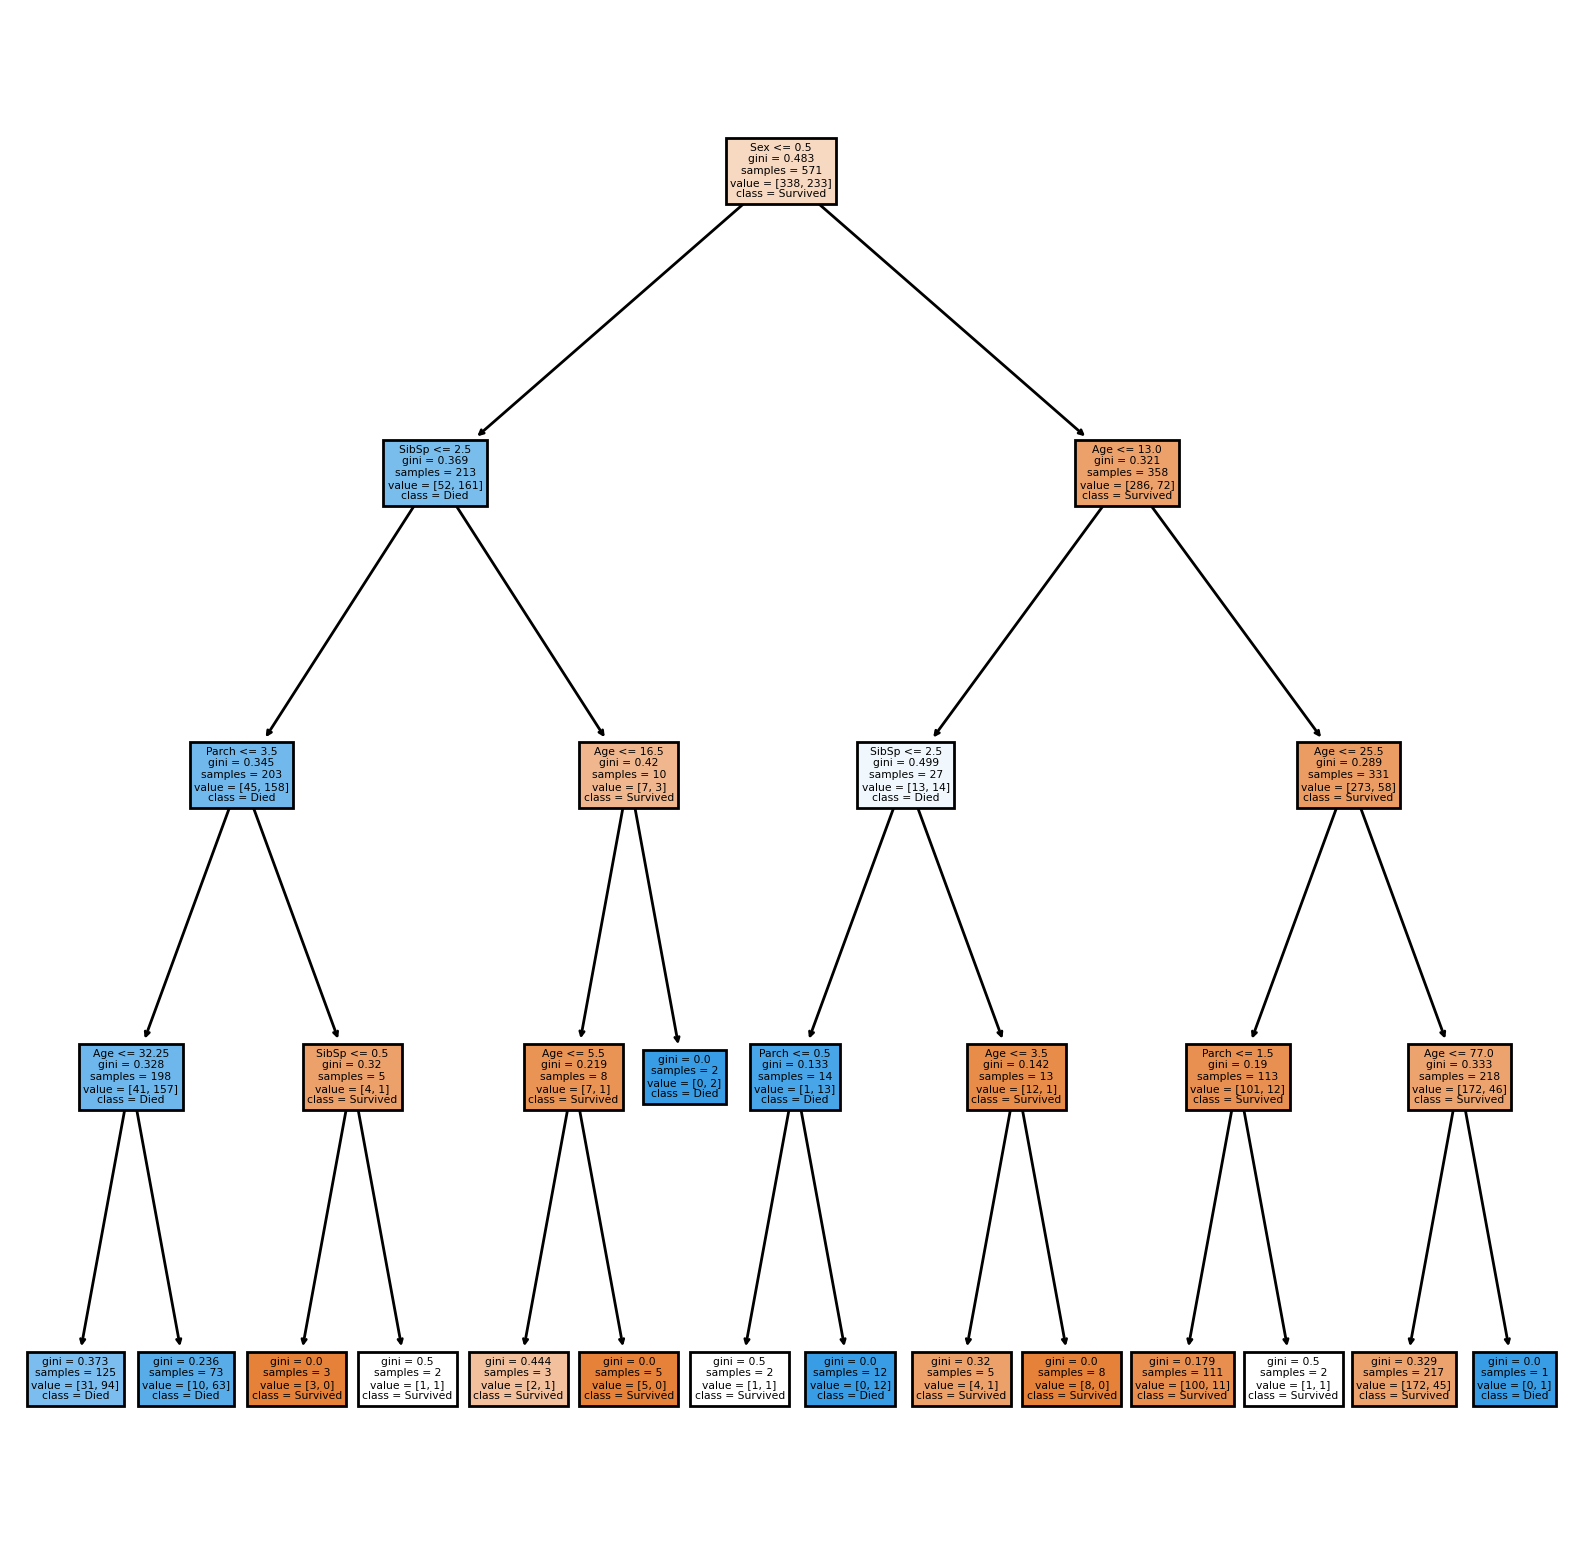

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=200)
tree.plot_tree(clf,feature_names=columns_x,
                  class_names = ['Survived','Died'],  
                   filled=True) 
fig.savefig('treeplot.png')

## Conclusion

In this notebook, you learned an interactive approach applying k-NN and Decision Trees, two machine learning algorithms. More specifically, we've explored data classification on the Titanic's passengers dataset.

The designed k-NN approach scored 81% accuracy and the Decision Tree scored 84% accuracy. We may say then that both of them achieved satisfactory results.

Run different solutions for the same problem is a good practice in Machine Learning and helps to discern the differences between approaches, and also find the best one for a type of problem.